<a href="https://colab.research.google.com/github/AbeRodz/computer-vision-II/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Integrador

## Integrantes

- Abraham Rodriguez
- Cecilia Sanchez

In [2]:
#!pip install torchmetrics
#!pip install --upgrade --no-cache-dir gdown

In [3]:
!nvidia-smi

Mon Aug 14 19:01:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8               8W / 285W |    606MiB / 12282MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import torch
import torchvision
import torchsummary
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
#import torchmetrics
#from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

c:\Users\Usuario\Documents\uba_abraham\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

Utility functions for plotting, and loading images

In [5]:
def plot_predicted_image(original, mask, predicted_mask):

    _, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(original.transpose(1,2,0))
    ax[0].set_title("Original")

    ax[1].imshow(mask.transpose(1,2,0))
    ax[1].set_title("original mask")
    
    ax[2].imshow(predicted_mask.transpose(1,2,0))
    ax[2].set_title("predicted mask")

    plt.show()

In [6]:
def load_dataset_paths(path: str):
    train_data_dir = f"{path}/dataset/training/image_2/"
    train_gt_dir = f"{path}/dataset/training/gt_image_2/"

    test_data_dir = f"{path}/dataset/testing/"
    return train_data_dir, train_gt_dir, test_data_dir

In [7]:
def open_images_np(path, masked = False):
  """
  open images concurrently by using a thread pool
  """
  temp = []
  def read_image(image):

    return Image.open(os.path.join(path,image)).resize((128, 128))

  images = os.listdir(path)
  images=sorted(images)
  if masked==True:
    images = [entry for entry in images if "road" in entry]

  with ThreadPoolExecutor() as executor:
    files = executor.map(read_image,images)
    for f in files:
      temp.append(np.asarray(f))
  return np.array(temp)

In [8]:
def show_image_list(images : list, nrows = 1, figsize = (12,8), cmap :list = ['gray'], titles = [""]):
    ncols = len(images)
    _, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)

    axes = axes.ravel()

    for i in range(len(axes)):
       axes[i].set_axis_off()
       if (cmap is None):
           axes[i].imshow(images[i])
           if (len(titles)>0):
               axes[i].set_title(titles[i])
       elif (len(cmap)>1):
           axes[i].imshow(images[i], cmap=cmap[i])
           if (len(titles)>0):
               axes[i].set_title(titles[i])

       else:
           axes[i].imshow(images[i], cmap=cmap[0])
           if (len(titles)>0):
               axes[i].set_title(titles[i])

In [9]:
def open_images_cv(path, masked = False):
  """
  open images concurrently by using a thread pool
  """
  temp = []
  def read_image(image):
    return cv.resize(cv.cvtColor(cv.imread(os.path.join(path,image)), cv.COLOR_BGR2RGB),(128,128))


  images = os.listdir(path)
  images=sorted(images)
  if masked==True:
    images = [entry for entry in images if "road" in entry]

  with ThreadPoolExecutor() as executor:
    files = executor.map(read_image,images)
    for f in files:
      temp.append(np.asarray(f))
  return np.array(temp)

La siguiente linea es un optimizador de cudnn

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')
#cd /content/drive/MyDrive/dataset/vision/kitti

In [12]:
train_data_dir, train_gt_dir, test_data_dir = load_dataset_paths('.')

In [13]:
data=open_images_np(train_data_dir,masked=False)

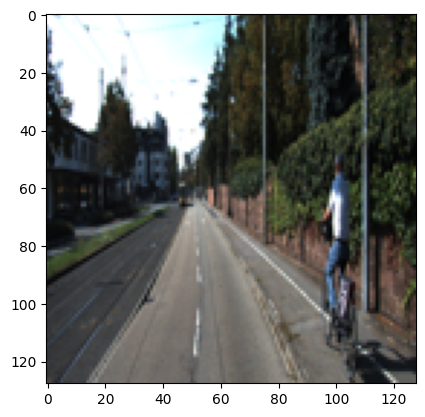

In [14]:
plt.imshow(data[0])

In [81]:
open_images_cv(train_data_dir,masked=False).shape

(289, 128, 128, 3)

In [15]:
data=open_images_cv(train_data_dir,masked=False)
masks=open_images_cv(train_gt_dir,masked=True)

# Binarizing masks

In [16]:
def binarize(mask: np.ndarray):
    """
    Binarizes the mask image, and transforms it onto grayscale
    """
    road_label =np.array([255, 0, 255])
    cond=np.all(mask == road_label, axis = 2)
    mask=mask * cond[..., np.newaxis]
    mask = cv.cvtColor(mask[..., :3],cv.COLOR_RGB2GRAY)
    return mask

In [17]:
def convert_to_binary_mask(masks: np.ndarray) -> np.ndarray:
    temp = []
    mask_length=len(masks)
    for i in range(mask_length):

        temp.append(binarize(masks[i]))
    binary_masks = np.array(temp)
    binary_masks=np.expand_dims(binary_masks, axis=-1)
    return binary_masks

In [18]:
binary_mask = convert_to_binary_mask(masks)
binary_mask.shape

(289, 128, 128, 1)

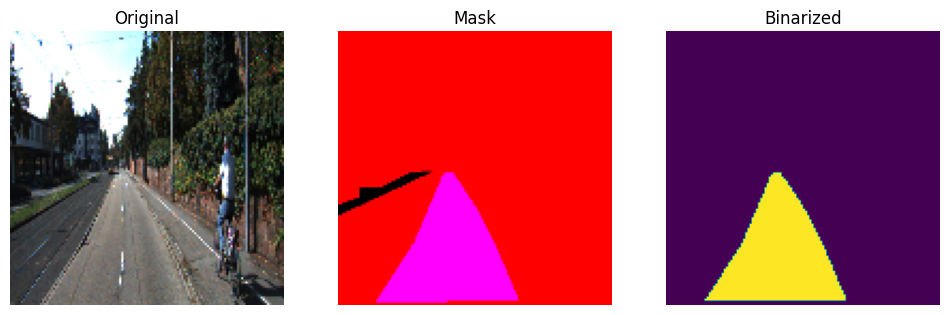

In [19]:
show_image_list([data[0], masks[0], binary_mask[0]],cmap=None,titles=["Original", "Mask","Binarized"])

In [20]:
binary_mask[binary_mask != 0.0]=1.0

In [21]:
data  = data / 255.0

## Data Augmentation

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(10,-10), p=0.5,border_mode=cv.BORDER_CONSTANT),
])

In [23]:
data=data.astype(np.float32)
binary_mask=binary_mask.astype(np.float32)

In [24]:
test_aug=augmentation_pipeline(image=data[5], mask=binary_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

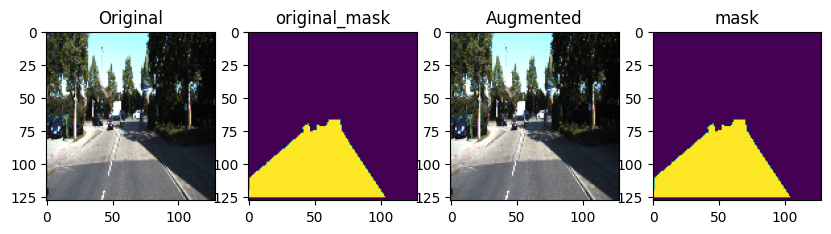

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(binary_mask[5])
ax[1].set_title("original_mask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()

In [26]:
num_augmented=3
for i in range(len(data)):
    for j in range(num_augmented):
      image = data[i]
      mask = binary_mask[i]

      augmented = augmentation_pipeline(image=image, mask=mask)

      image_augmented = augmented["image"]
      mask_augmented = augmented["mask"]
      data = np.vstack((data, image_augmented[np.newaxis,...]))
      binary_mask = np.vstack((binary_mask, mask_augmented[np.newaxis,...]))

In [27]:
type(data.dtype)

numpy.dtype[float32]

In [28]:
data.shape

(1156, 128, 128, 3)

In [29]:
binary_mask.shape

(1156, 128, 128, 1)

In [30]:
def test_train_validation_split(data : np.ndarray, true_masks: np.ndarray,train_size = 0.8):
    """
    Splits dataset onto train, test, and validation datasets
    """
    train_set_size = int(len(data) * train_size)
    validation_set_size = int(len(data) * 0.1)
    test_set_size = len(data) - train_set_size - validation_set_size
    
    X_test=data[:test_set_size].transpose((0, 3, 1, 2))
    y_test=true_masks[:test_set_size].transpose((0, 3, 1, 2))


    data=data[test_set_size:]
    true_masks=true_masks[test_set_size:]

    # shuffle
    shuffled_indices = np.random.permutation(len(data))
    shuffled_data = data[shuffled_indices]
    shuffled_masks = true_masks[shuffled_indices]

    X_train=shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
    y_train=shuffled_masks[:train_set_size].transpose((0, 3, 1, 2))

    X_val=shuffled_data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
    y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))


    return X_train, y_train, X_test, y_test , X_val, y_val 

In [31]:
X_train, y_train, X_test, y_test , X_val, y_val  = test_train_validation_split(data,binary_mask)

In [32]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, images,masks):
        self.images=images
        self.masks=masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image= self.images[index]
        mask=self.masks[index]
        return image,mask

Dataloaders Asincronos

In [33]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=64,shuffle=False)

print(f"Train dataloader length: {len(train_dataloader)} batches of size {64}")
print(f"Validation dataloader length: {len(val_dataloader)} batches of size {64}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {64}")

Train dataloader length: 15 batches of size 64
Validation dataloader length: 2 batches of size 64
Test dataloader length: 2 batches of size 64


# Creando U-NET

## U-Net

In [35]:
import torchvision.transforms.functional as TF

In [39]:
class DoubleConv(torch.torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
class DownBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = torch.nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = torch.nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(torch.nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = torch.nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    
model = UNet()

In [34]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() # essentail to use torch.nn.Module
        #ex : for the first layer
        #in_channels would be 3 for RGB image
        #out_channels would be 64
        #bias is set to false because we apply batch norm later so it's unnecassary
        self.dconv=torch.nn.Sequential(torch.nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
                                 torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dconv(x)



class UNET(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()

        self.ups = torch.nn.ModuleList()
        self.downs = torch.nn.ModuleList()

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(torch.nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #this is not deconv this just upsampling
            self.ups.append(DoubleConv(feature*2, feature))



        self.left_over = DoubleConv(features[-1], features[-1]*2) #this represents the last part which starts the UP phase

        self.final_conv = torch.nn.Conv2d(features[0], out_channels, kernel_size=1) #output segmentation  map

    def forward(self,x):
        skip_connections = []

        #starting the down phase will iterate through the downs module
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)#save this to feed it later
            x=self.pool(x)

        #to move from left to right we pass through the "left_over"

        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2): #our goal it so feed to transposed conv and add skipped connection ups has 2 steps in each so we will make it a step of 2

            sc=skip_connections[idx//2]
            x=self.ups[idx](x) #step 1

            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) #concatination step
            x = self.ups[idx+1](concat_skip) #step 2


        return torch.sigmoid(self.final_conv(x))#last step in forward

## Instanciando U-Net

In [35]:
import torch.optim as optim

EPOCHS=80
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = smp.utils.losses.DiceLoss()
LEARNING_RATE=1e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Implementacion de EarlyStopping

In [40]:
import copy

class EarlyStopping():
  """
  EarlyStopping serves as a mechanism to check if the loss does not have a considerable change, this can help to prevent overfitting
  and reduce the number of epochs (training time)
  """
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [36]:
class Trainer():
  """
  Class that wraps the training and evaluation of a model
  """
  def __init__(self, model : torch.nn.Module, train_data_loader: DataLoader,test_data_loader: DataLoader ,loss_fn:torch.nn.Module, optimizer: torch.optim.Optimizer, device: str):
    self.model = model
    self.train_data_loader = train_data_loader
    self.test_data_loader = test_data_loader
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device

  def train_model(self,use_amp = False):

    model = self.model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    losses = []
    bar = tqdm(self.train_data_loader)
    for train_input, train_mask in bar:
        train_mask = train_mask.to(self.device)
        train_input=train_input.to(self.device)
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            output = model(train_input)
            loss = loss_fn(output, train_mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # outputs=model(train_input.float())
        # loss = loss_fn(outputs.float(), train_mask.float())
        losses.append(loss.item())
        #loss.backward()
        #optimizer.step()
        #optimizer.zero_grad()
        for param in model.parameters():
          param.grad = None
        bar.set_description(f"loss {loss:.5f}")
    return np.mean(losses)

  def eval_model(self):
    model = self.model.eval()

    losses = []
    bar = tqdm(self.test_data_loader)
    with torch.no_grad():
        for val_input, val_mask in bar:

            val_mask = val_mask.to(self.device)
            val_input=val_input.to(self.device)
            outputs=model(val_input.float())

            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())
            bar.set_description(f"val_loss {loss:.5f}")

    return np.mean(losses)

## Training

In [37]:
from collections import defaultdict
history = defaultdict(list)

In [42]:
torch.compile(model)

RuntimeError: Windows not yet supported for torch.compile

In [38]:
train = Trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer, DEVICE)

In [41]:
loss=np.inf

es = EarlyStopping(patience = 5)
done = False
for epoch in range(EPOCHS) :

    train_loss = train.train_model(True)
    print(epoch)
    val_loss = train.eval_model()
    if es(model,val_loss):
      done = True
      print(f'Patience ran out : {es.status}')
      break
    print(f'EStop:[{es.status}]')
    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 50)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}\n')   

    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state_unet.bin')
        loss = val_loss


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

loss 0.41896: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


0


val_loss 0.69428: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]


EStop:[0/5]
Epoch 1/80
--------------------------------------------------
Train loss 0.49692344665527344
Val   loss 0.6956822872161865



loss 0.31750: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


1


val_loss 0.59710: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


EStop:[0/5]


loss 0.32182: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


2


val_loss 0.37037: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


EStop:[0/5]


loss 0.30428: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


3


val_loss 0.30310: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


EStop:[0/5]


loss 0.20719: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


4


val_loss 0.24872: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


EStop:[0/5]


loss 0.19485: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


5


val_loss 0.25906: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


EStop:[1/5]
Epoch 6/80
--------------------------------------------------
Train loss 0.1901272217432658
Val   loss 0.26485779881477356



loss 0.13337: 100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


6


val_loss 0.17806: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


EStop:[0/5]


loss 0.12225: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


7


val_loss 0.15264: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


EStop:[0/5]


loss 0.09761: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


8


val_loss 0.20321: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


EStop:[1/5]


loss 0.09769: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


9


val_loss 0.12771: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


EStop:[0/5]


loss 0.09402: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


10


val_loss 0.11109: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


EStop:[0/5]
Epoch 11/80
--------------------------------------------------
Train loss 0.0977146824200948
Val   loss 0.10623431205749512



loss 0.08286: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


11


val_loss 0.11985: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


EStop:[1/5]


loss 0.07816: 100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


12


val_loss 0.07635: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


EStop:[0/5]


loss 0.05474: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


13


val_loss 0.08177: 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


EStop:[1/5]


loss 0.06148: 100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


14


val_loss 0.06694: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


EStop:[0/5]


loss 0.06963: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


15


val_loss 0.09909: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


EStop:[1/5]
Epoch 16/80
--------------------------------------------------
Train loss 0.06215877930323283
Val   loss 0.09475970268249512



loss 0.05779: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


16


val_loss 0.05946: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


EStop:[0/5]


loss 0.06275: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


17


val_loss 0.05452: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


EStop:[0/5]


loss 0.06003: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


18


val_loss 0.08113: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


EStop:[1/5]


loss 0.05458: 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


19


val_loss 0.06546: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


EStop:[2/5]


loss 0.05770: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]


20


val_loss 0.06028: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


EStop:[0/5]
Epoch 21/80
--------------------------------------------------
Train loss 0.05289913415908813
Val   loss 0.055019646883010864



loss 0.04961: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


21


val_loss 0.05374: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


EStop:[1/5]


loss 0.04475: 100%|██████████| 15/15 [00:02<00:00,  5.05it/s]


22


val_loss 0.04825: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


EStop:[0/5]


loss 0.04017: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


23


val_loss 0.04910: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


EStop:[0/5]


loss 0.04734: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


24


val_loss 0.05157: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


EStop:[1/5]


loss 0.04712: 100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


25


val_loss 0.04635: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


EStop:[0/5]
Epoch 26/80
--------------------------------------------------
Train loss 0.04350898265838623
Val   loss 0.044809043407440186



loss 0.04869: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


26


val_loss 0.04420: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


EStop:[0/5]


loss 0.04411: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


27


val_loss 0.05061: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


EStop:[1/5]


loss 0.04415: 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


28


val_loss 0.04743: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


EStop:[2/5]


loss 0.05748: 100%|██████████| 15/15 [00:02<00:00,  5.50it/s]


29


val_loss 0.06038: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


EStop:[3/5]


loss 0.04396: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]


30


val_loss 0.05256: 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


EStop:[4/5]
Epoch 31/80
--------------------------------------------------
Train loss 0.04624729156494141
Val   loss 0.05354800820350647



loss 0.04288: 100%|██████████| 15/15 [00:02<00:00,  5.78it/s]


31


val_loss 0.04602: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

Patience ran out : Stopped on 5


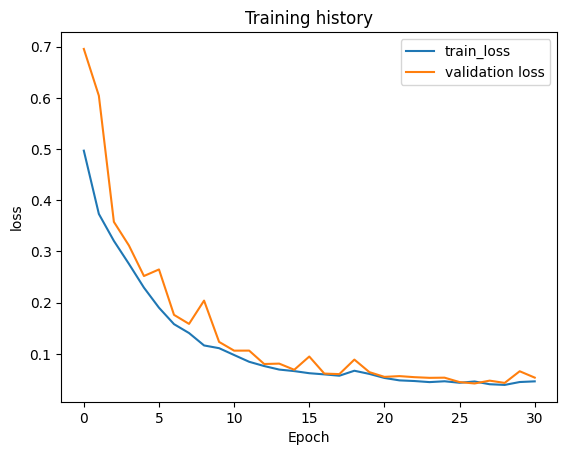

In [42]:
def plot_loss(history : dict):
  plt.plot(history['train_loss'], label='train_loss')
  plt.plot(history['val_loss'], label='validation loss')

  plt.title('Training history')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend()
plot_loss(history)

# Predictions

In [43]:
prediction=model(torch.tensor(X_test[56][np.newaxis,...],device=DEVICE)).cpu().detach().numpy()

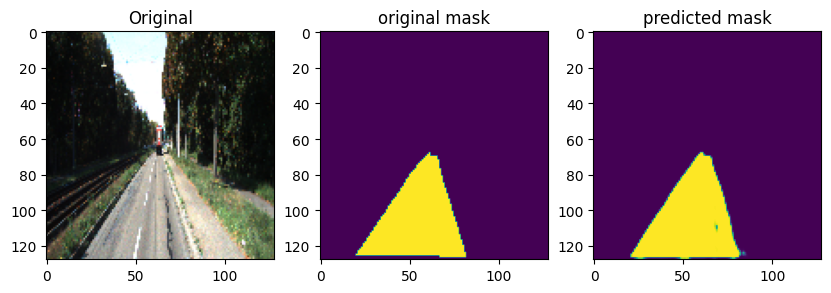

In [44]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(prediction[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

In [45]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [46]:
loss,masks=get_predicted_masks(model,test_dataloader,loss_fn,DEVICE)
print(loss)

0.04177558422088623


In [47]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

# Testing

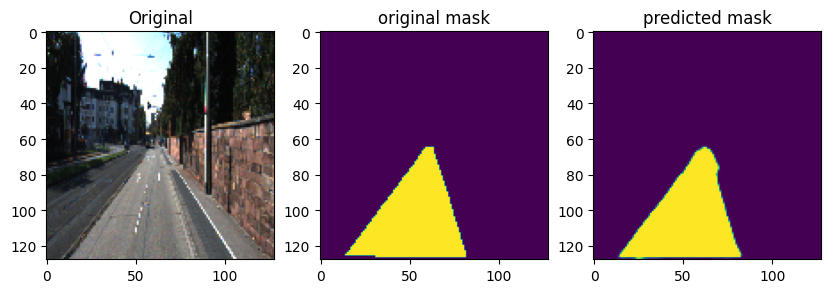

In [48]:
plot_predicted_image(X_test[2],y_test[2],predicted_masks[2])

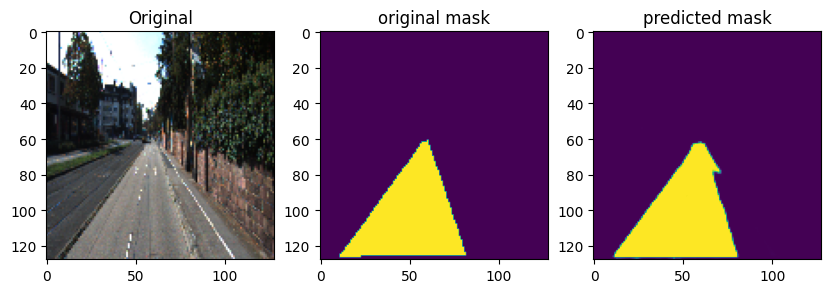

In [49]:
plot_predicted_image(X_test[1],y_test[1],predicted_masks[1])

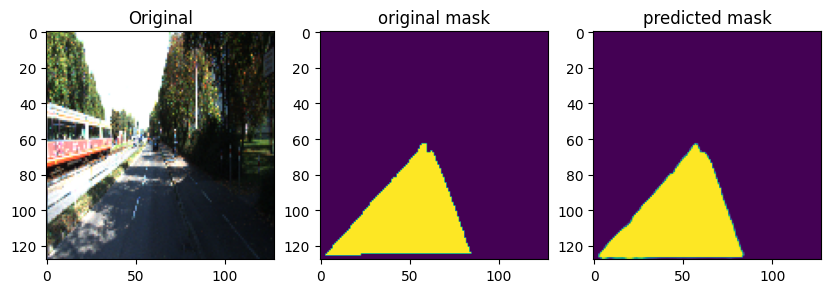

In [50]:
plot_predicted_image(X_test[14],y_test[14],predicted_masks[14])

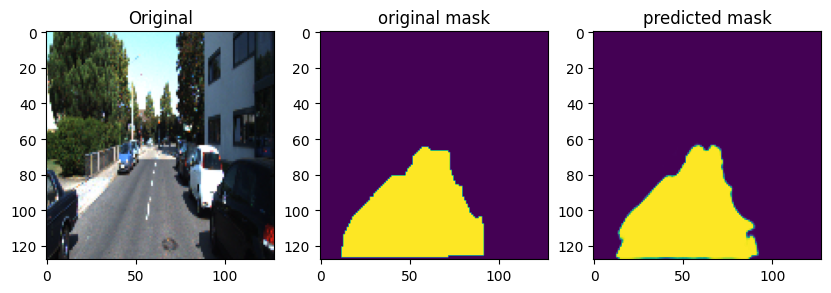

In [51]:
plot_predicted_image(X_test[4],y_test[4],predicted_masks[4])

# Deeplab

In [52]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [53]:
from segmentation_models_pytorch import utils

In [55]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
   utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [56]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [57]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    es = EarlyStopping(patience = 5)
    done = False
    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        if es(model,valid_logs['dice_loss']):
            done = True
            print(f'Patience ran out : {es.status}')
            break
        print(f'EStop:[{es.status}]')
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00,  2.97it/s, dice_loss - 0.4936, iou_score - 0.4737]
EStop:[0/5]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00, 18.18it/s, dice_loss - 0.2356, iou_score - 0.7502]
EStop:[0/5]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00, 17.54it/s, dice_loss - 0.1204, iou_score - 0.8607]
EStop:[0/5]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00, 18.52it/s, dice_loss - 0.08836, iou_score - 0.8722]
EStop:[0/5]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, dice_loss - 0.06865, iou_score - 0.8923]
EStop:[0/5]
Model saved!

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00, 18.35it/s, dice_loss - 0.06943, iou_score - 0.8877]
EStop:[1/5]

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00, 17.70it/s, dice_loss - 0.06493, iou_score - 0.8923]
EStop:[0/5]
Model saved!

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00, 18.69it/s, dice_loss - 0.05188, iou_score - 0.9131]
EStop:[0/

In [58]:
import pandas as pd

In [59]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
dice_loss,0.421623,0.222631,0.130990,0.088363,0.072311,0.061327,0.053967,0.048551,0.044181,0.040427,...,0.022907,0.021853,0.021026,0.020714,0.019873,0.020266,0.019991,0.019531,0.018678,0.018328
iou_score,0.541267,0.765310,0.845514,0.878520,0.893082,0.905027,0.914205,0.921746,0.928305,0.934404,...,0.961830,0.963603,0.964998,0.965411,0.966806,0.965678,0.966054,0.966716,0.968439,0.968892


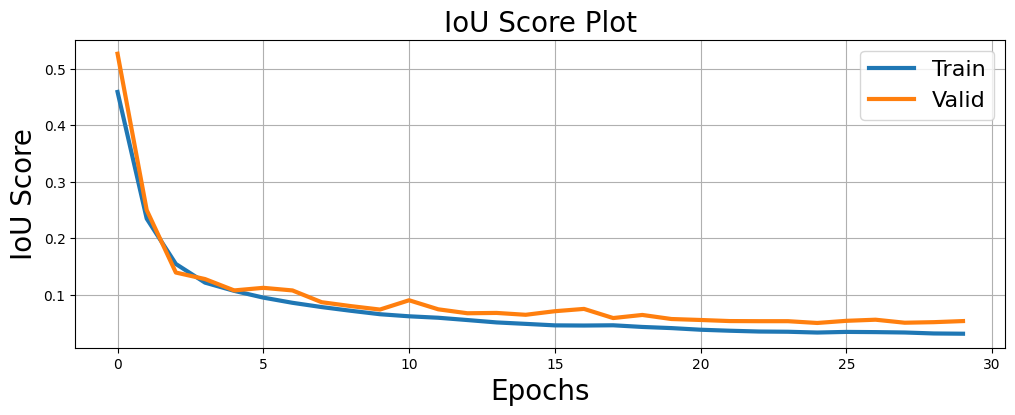

In [60]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(),1 - train_logs_df.iou_score, lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(),1 - valid_logs_df.iou_score, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

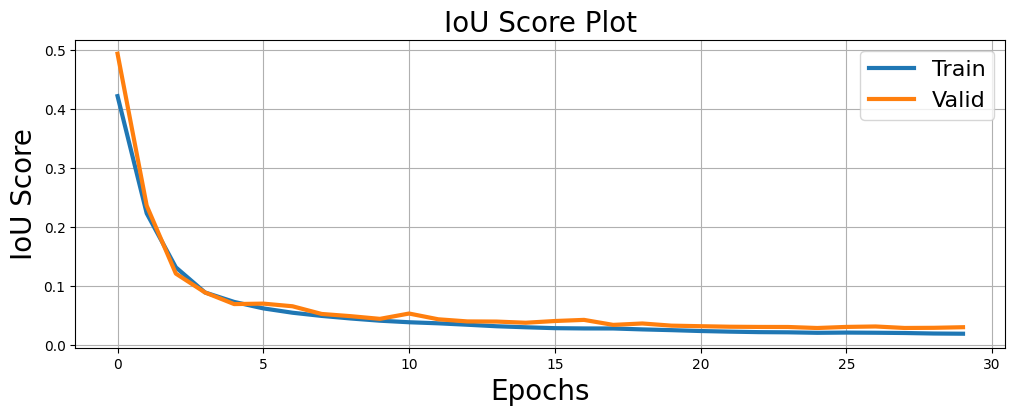

In [61]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [62]:
loss,masks=get_predicted_masks(model,test_dataloader,loss,DEVICE)
print(loss)

0.028866350650787354


In [63]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

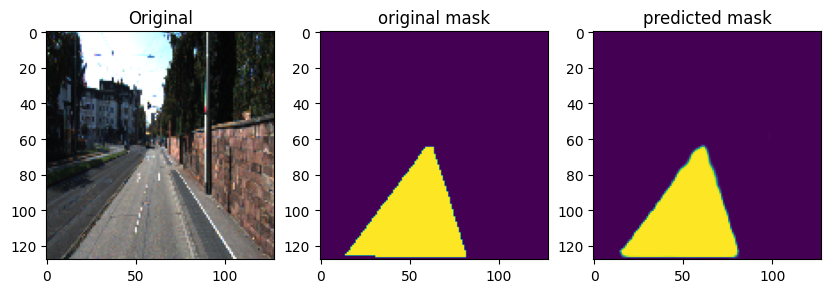

In [64]:
plot_predicted_image(X_test[2],y_test[2],predicted_masks[2])

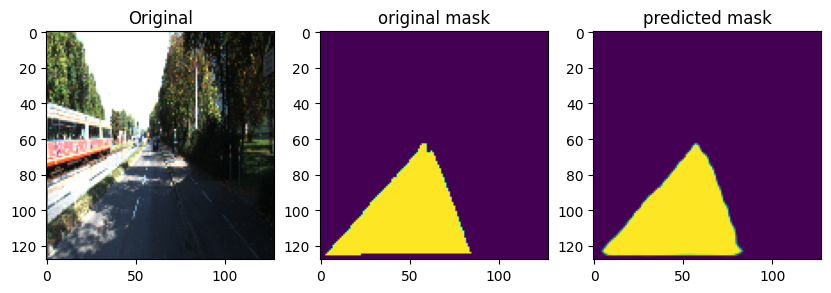

In [65]:
plot_predicted_image(X_test[14],y_test[14],predicted_masks[14])

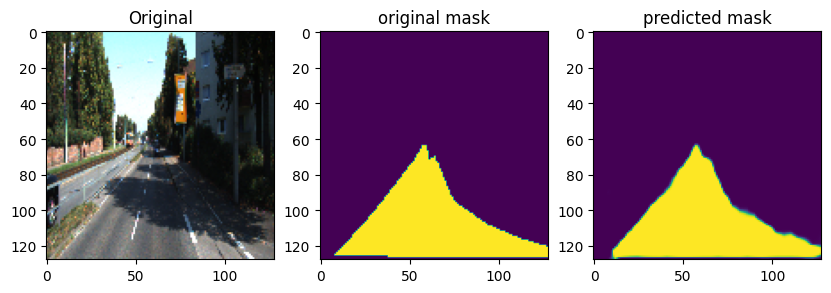

In [66]:
plot_predicted_image(X_test[12],y_test[12],predicted_masks[12])

# U-NET++

In [67]:
ENCODER = 'xception'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [68]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
   utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unetplus-imagenet-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/unetplus-imagenet-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [69]:
model.name

'unetplusplus-xception'

In [70]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [71]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    es = EarlyStopping(patience = 5)
    done = False
    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        if es(model,valid_logs['dice_loss']):
            done = True
            print(f'Patience ran out : {es.status}')
            break
        print(f'EStop:[{es.status}]')
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s, dice_loss - 0.4679, iou_score - 0.4969]
EStop:[0/5]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s, dice_loss - 0.253, iou_score - 0.8134]
EStop:[0/5]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s, dice_loss - 0.1277, iou_score - 0.8897]
EStop:[0/5]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00, 13.16it/s, dice_loss - 0.08304, iou_score - 0.9148]
EStop:[0/5]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s, dice_loss - 0.0642, iou_score - 0.9225]
EStop:[0/5]
Model saved!

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s, dice_loss - 0.0563, iou_score - 0.9216]
EStop:[0/5]

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, dice_loss - 0.04815, iou_score - 0.9302]
EStop:[0/5]
Model saved!

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s, dice_loss - 0.04626, iou_score - 0.9286]
EStop:[0/5]


In [72]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
dice_loss,0.438445,0.223528,0.134355,0.087860,0.065244,0.055832,0.046824,0.043370,0.040801,0.038464,...,0.009505,0.009361,0.008924,0.008643,0.008077,0.008106,0.011021,0.008994,0.007999,0.007389
iou_score,0.602067,0.848831,0.890873,0.912037,0.924010,0.926715,0.935759,0.937336,0.938575,0.940501,...,0.983686,0.983885,0.984657,0.985153,0.986213,0.986144,0.980105,0.984182,0.986114,0.987283


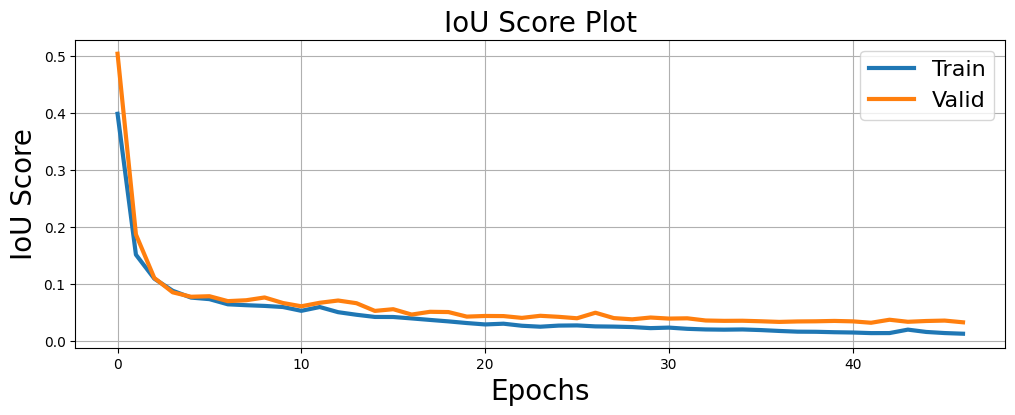

In [73]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(),1 - train_logs_df.iou_score, lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(),1 - valid_logs_df.iou_score, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [74]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [106]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [75]:
loss,masks=get_predicted_masks(model,test_dataloader,loss,DEVICE)
print(loss)

0.012817531824111938


In [76]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

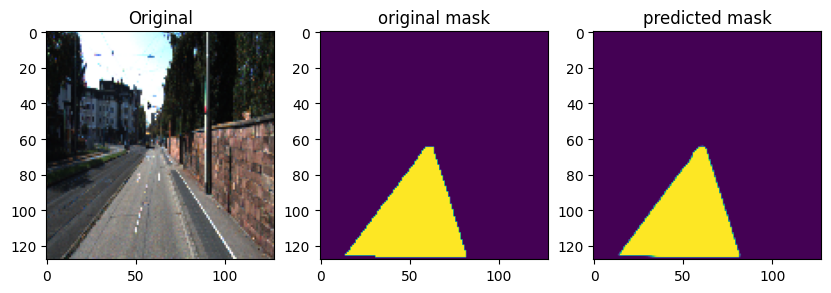

In [77]:
plot_predicted_image(X_test[2],y_test[2],predicted_masks[2])

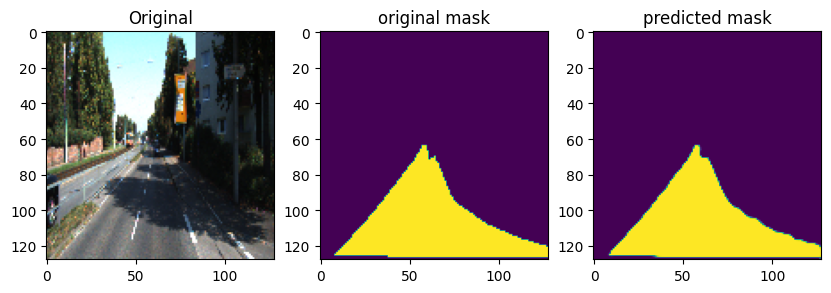

In [78]:
plot_predicted_image(X_test[12],y_test[12],predicted_masks[12])

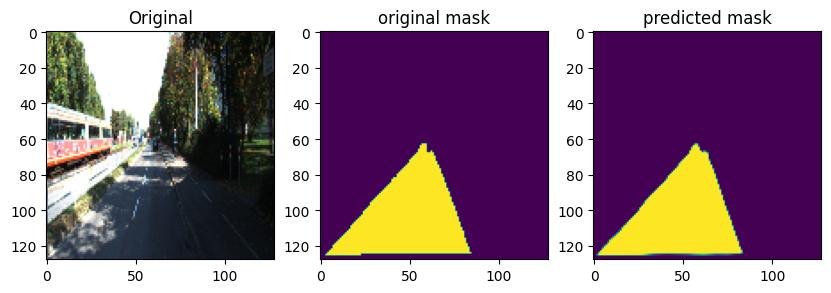

In [79]:
plot_predicted_image(X_test[14],y_test[14],predicted_masks[14])

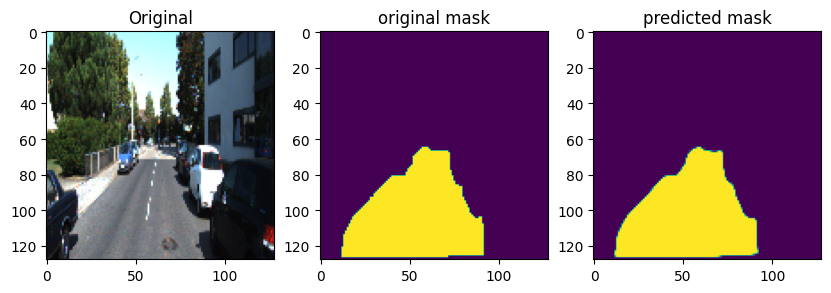

In [82]:
plot_predicted_image(X_test[4],y_test[4],predicted_masks[4])

# Probando con videos

<video width="320" height="240" 
       src="./dataset/testing/challenge.mp4"
       controls>
</video>

In [80]:
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv.addWeighted(initial_img, α, img, β, γ)

In [356]:
def save_to_video(model, video_path, output_name):
    
    vs = cv.VideoCapture(video_path)
    _, frame = vs.read()
    H, W, _ = frame.shape
    vs.release()
    #fourcc = cv.VideoWriter_fourcc(*'MP4V')
    fourcc = cv.VideoWriter_fourcc('M','J','P','G')
    out = cv.VideoWriter(f'{output_name}.avi', fourcc, 30, (W, H), True)
    cap = cv.VideoCapture(video_path)
    idx = 0
    while True:
        ret, frame = cap.read()
        if ret == False:
            cap.release()
            out.release()
            break
        H, W, _ = frame.shape
        
        ori_frame = frame

        frame = cv.resize(cv.cvtColor(frame,cv.COLOR_BGR2RGB),(128,128))

        frame = np.expand_dims(frame, axis=0)
        frame = frame / 255.0

        mask = model(torch.tensor(frame.transpose((0, 3, 1, 2)),device=DEVICE).float()).cpu().detach().numpy()
        #mask = mask > 0.5
        mask = mask.astype(np.float32)
        
        mask = cv.resize(mask[0].transpose(1,2,0), (W, H))
        mask = np.expand_dims(mask, axis=-1)
        zero_image = np.zeros_like(mask)
        mask = np.dstack((mask, zero_image, zero_image)) * 255
        mask = np.asarray(mask, np.uint8)
        combine_frame = weighted_img(mask, ori_frame)
        #cv.imwrite(f"video/{idx}_video.png", combine_frame)
        idx += 1

        out.write(combine_frame)

In [358]:
video_path = "./dataset/testing/solidWhiteRight.mp4"
save_to_video(model,video_path,"output_4")